In [1]:
import numpy as onp
import jax
import jax.numpy as np

from jax import lax, random
from jax.api import grad, jit, vmap
from jax.config import config
from jax.experimental import optimizers
from jax.experimental.stax import logsoftmax

config.update('jax_enable_x64', True)

from neural_tangents import stax

from functools import partial

# Attacking
from cleverhans.utils import clip_eta, one_hot

# Plotting
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import *

sns.set_style(style='white')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

"""
diag_reg:
    a scalar representing the strength of the diagonal regularization for
    `k_train_train`, i.e. computing `k_train_train + diag_reg * I` during
    Cholesky factorization or eigendecomposition.
"""
diag_reg = 1e-5

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

# data

In [2]:
DATASET = 'cifar10'
class_num   = 10
image_shape = None

train_size = 32
test_size  = 16

if DATASET =='mnist':
    image_shape = (28, 28)
elif DATASET == 'cifar10':
    image_shape = (32, 32, 3)

In [3]:
x_train_all, y_train_all, x_test_all, y_test_all = tuple(onp.array(x) for x in get_dataset(DATASET, None, None, 
                                                                                  do_flatten_and_normalize=False))

In [4]:
# shuffle
seed = 0
x_train_all, y_train_all = shaffle(x_train_all, y_train_all, seed)

In [5]:
# down sample
x_train = x_train_all[:train_size]
y_train = y_train_all[:train_size]

x_test = x_test_all[:test_size]
y_test = y_test_all[:test_size]

In [6]:
device_id = jax.devices()[0]

In [7]:
# move to gpu

# x_train = jax.device_put(x_train, device=device_id)
# y_train = jax.device_put(y_train, device=device_id)

# x_test = jax.device_put(x_test, device=device_id)
# y_test = jax.device_put(y_test, device=device_id)

In [8]:
x_train, x_test = x_train.reshape((-1, *image_shape)), x_test.reshape((-1, *image_shape))

# model

In [9]:
def accuracy(mean, ys):
    return np.mean(np.argmax(mean, axis=-1) == np.argmax(ys, axis=-1))

In [10]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Conv(64, (3, 3), W_std=1.76, b_std=0.18),
    stax.Erf(),
    stax.Conv(64, (3, 3), W_std=1.76, b_std=0.18),
    stax.Erf(),
    stax.Conv(128, (3, 3), W_std=1.76, b_std=0.18),
    stax.Erf(),
    stax.Conv(128, (3, 3), W_std=1.76, b_std=0.18),
    stax.Flatten(),
    stax.Dense(class_num)
)

# infinite width

In [11]:
batch_inf_kernel_fn = nt.batch(kernel_fn, batch_size=256, store_on_device=False)

kernel_train_m = batch_inf_kernel_fn(x_train, None, 'ntk')

eigval_inf, eigv_inf = np.linalg.eigh(kernel_train_m + np.eye(train_size)*diag_reg)

/home/nthudatalab1/.local/lib/python3.6/site-packages/neural_tangents/utils/batch.py:573: UserWarning: Batch size is reduced from requested 256 to effective 32 to fit the dataset.
  'fit the dataset.' % (batch_size, n2_batch_size))


# finite width

In [12]:
rng_key = jax.random.PRNGKey(2021)

In [13]:
_, params = init_fn(rng_key, x_train.shape)

In [14]:
fin_kernel_fn = nt.empirical_kernel_fn(apply_fn)

In [15]:
kernel_train_m = fin_kernel_fn(x_train, None, 'ntk', params)

eigval_fin, eigv_fin = np.linalg.eigh(kernel_train_m + np.eye(train_size)*diag_reg)

RuntimeError: Resource exhausted: Out of memory while trying to allocate 7089553472 bytes.

In [ ]:
eigval_fin

In [ ]:
eigval_inf

In [16]:
eigval_fin

DeviceArray([5.93887756e-03, 9.98199433e-03, 1.02567796e-02,
             1.17357109e-02, 1.18394739e-02, 1.28843496e-02,
             1.42401875e-02, 1.51794366e-02, 1.73091420e-02,
             1.80853791e-02, 1.87734252e-02, 2.04387219e-02,
             2.22238180e-02, 2.40214833e-02, 2.50885842e-02,
             2.73413246e-02, 2.90606836e-02, 3.16521401e-02,
             3.32691900e-02, 3.78575050e-02, 3.85257845e-02,
             4.22482309e-02, 4.89536494e-02, 5.18303621e-02,
             6.07414383e-02, 7.08595933e-02, 7.19905355e-02,
             8.36612248e-02, 1.29537112e-01, 1.78933951e-01,
             3.27661149e-01, 7.25066728e+00], dtype=float64)

In [17]:
eigval_inf

DeviceArray([0.01445957, 0.01499361, 0.01668931, 0.01812301, 0.01815161,
             0.0194101 , 0.02017103, 0.02141248, 0.02215153, 0.02558869,
             0.02612818, 0.02783976, 0.0304697 , 0.03150077, 0.03248604,
             0.03522494, 0.0383115 , 0.04016265, 0.04155243, 0.04679086,
             0.04892359, 0.04967646, 0.05348373, 0.06364327, 0.06870824,
             0.07328489, 0.08197666, 0.08835752, 0.12980779, 0.16313607,
             0.32162759, 6.34702555], dtype=float64)

In [14]:
# accuracy(y_predict, y_test)
# DeviceArray(0.6498, dtype=float64)

In [15]:
def model_fn(kernel_fn, obj_fn, x_train=None, x_test=None, fx_train_0=0., fx_test_0=0., t=None, ntk_train_train=None):
    # Kernel
    if ntk_train_train is None:
        ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    
    if obj_fn == 'train':
        return ntk_train_train
    elif obj_fn == 'test':
        ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
        # Prediction
        predict_fn = nt.predict.gradient_descent_mse(ntk_train_train, y_train, diag_reg=diag_reg) # no convariance
        return predict_fn(t, fx_train_0, fx_test_0, ntk_test_train) # fx_train_0, fx_test_0 = (0, 0) for infinite width
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

# loss

In [16]:
@jit
def l2_loss_v1(logits, labels, weighting=1):
    """
    Tensorflow version of L2 loss (without sqrt)
    """
    return np.sum(((logits - labels)**2) * weighting) / 2
    
@jit
def l2_loss_v2(logits, lables):
    """
    Normal L2 loss
    """
    return np.linalg.norm(logits - labels)

@jit
def cross_entropy_loss(logits, lables):
    return -np.sum(logsoftmax(logits) * lables)
    
@jit
def mse_loss(logits, lables):
    return 0.5 * np.mean((logits - lables) ** 2)

In [20]:
def evaluate(x_train, x_test, model_fn, kernel_fn, t=None, c=0, attack_type=None, ntk_train_train=None):
    y_train_predict, y_test_predict = model_fn(kernel_fn, 'test', 
                                               x_train, x_test, t=t, ntk_train_train=ntk_train_train)
    acc = accuracy(y_test_predict, y_test)
    print("Robustness({:s}): {:.2f}".format(attack_type, acc))
    
    return acc

In [22]:
def inv(k):
        #inverse with diag_reg
        return onp.linalg.inv(k + diag_reg * onp.eye(k.shape[0]))

In [18]:
time_steps = [16**i for i in range(0, 5)]
time_steps.append(np.inf)

In [30]:
def plt_samples(arr, attack_type, layer):
    fig, axs = plt.subplots(2, 4, figsize=(6, 3), sharex=True)
    for row, ax in enumerate(axs):
        for idx, a in enumerate(ax):
            img = arr[idx + row*4].reshape(image_shape)
            a.axis('off')
            a.xaxis.set_visible(False)
            a.yaxis.set_visible(False)
            a.imshow(img, cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

In [31]:
def save_samples(arr, attack_type, layer):
    fig, axs = plt.subplots(2, 4, figsize=(6, 3), sharex=True)
    for row, ax in enumerate(axs):
        for idx, a in enumerate(ax):
            img = arr[idx + row*4].reshape(image_shape)
            a.axis('off')
            a.xaxis.set_visible(False)
            a.yaxis.set_visible(False)
            a.imshow(img, cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.savefig("./fig-%s-untargeted/%s_layer_%d.png"%(DATASET ,attack_type, layer+1), dpi=150)
    plt.show()

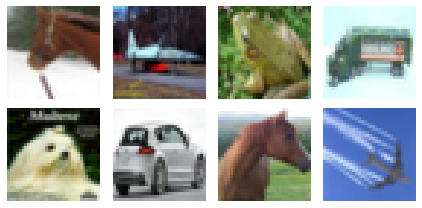

In [32]:
plt_samples(x_test, 'clean', 0)